In [34]:
from matplotlib import pyplot as plt
import tensorflow as tf 
from config import config
import mobilenet_model
import numpy as np
from skimage import io
from plot import *
from post_proc import *
import os
from tensorflow.keras.optimizers import Adam
from dataset.generators import get_dataset
from dataset.label_maps import PredictionData
import matplotlib.pyplot as plt

ds_val, ds_val_size = get_dataset(config.VAL_ANNO_FILE, config.VAL_IMG_DIR, config.BATCH_SIZE, True, config.IMAGE_SHAPE)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Loading image annot 0/5000
Loading image annot 2000/5000
Loading image annot 4000/5000


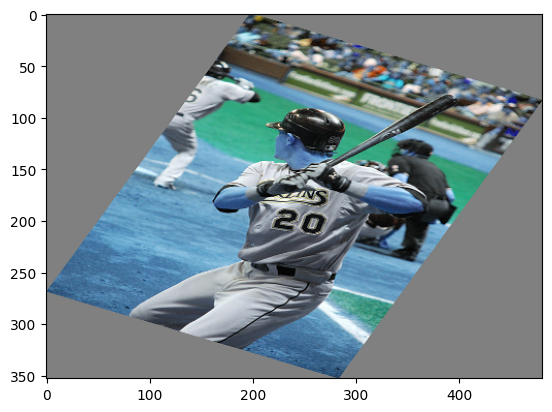

In [35]:
input_img = None
raw_kp_map = None
for images, labels in ds_val.take(1):  # only take first element of dataset
    input_img = images.numpy()
    raw_kp_map = labels.numpy()
from matplotlib.patches import Circle
plt.imshow(input_img[0])

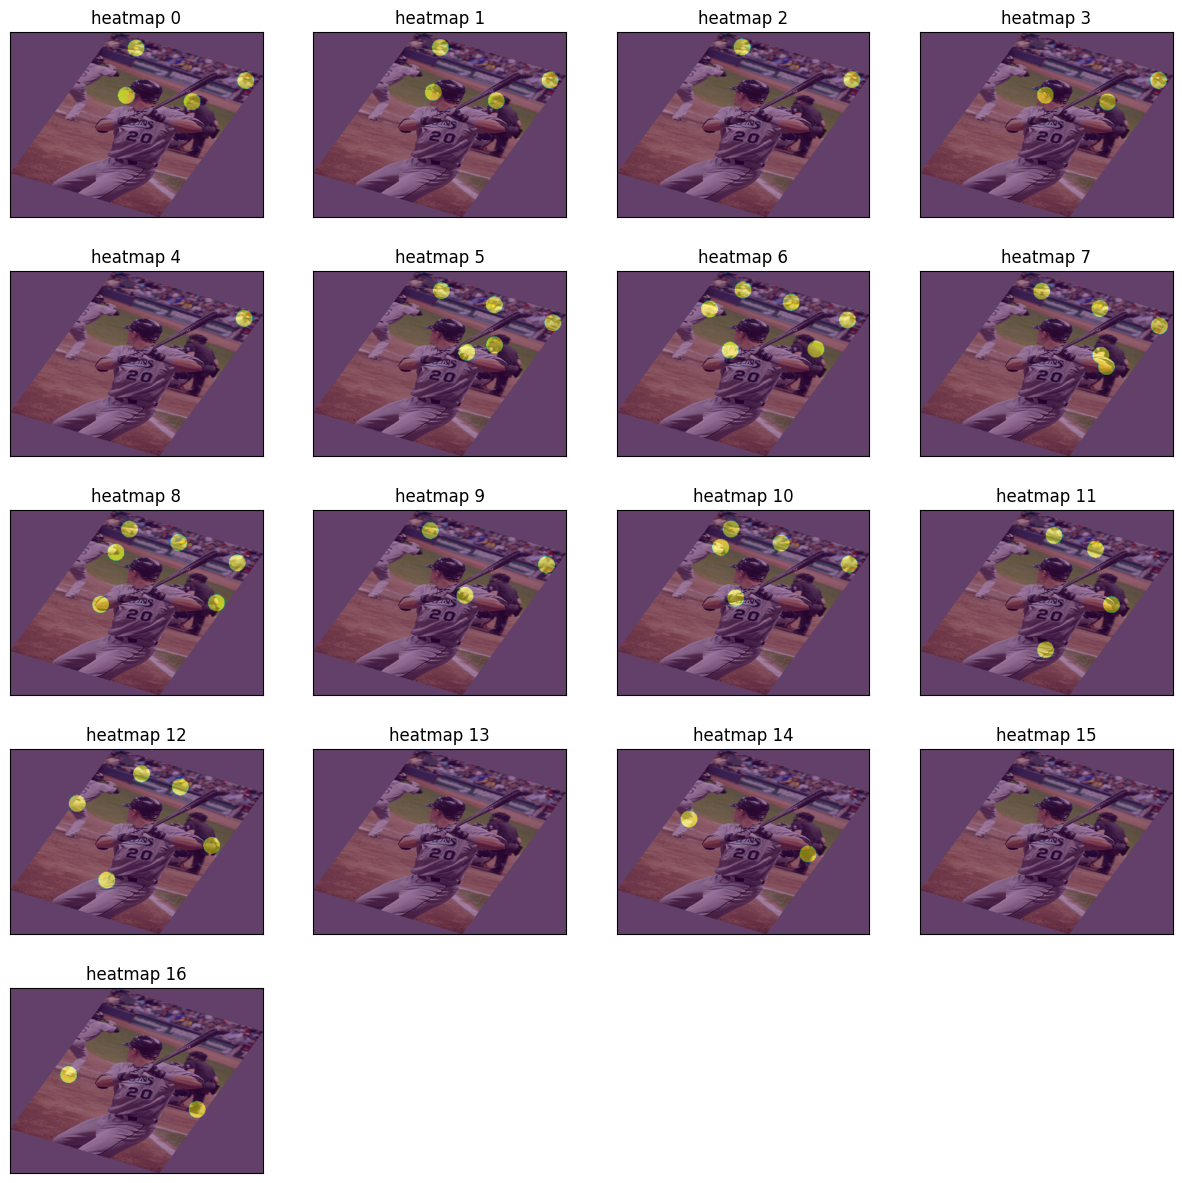

In [36]:
pred_data = PredictionData(raw_kp_map[0])
kp_maps = pred_data.kp_heatmaps()
figure = plt.figure(figsize=(15, 15))
for i in range(17):
    plt.subplot(5, 4, i+1, title='heatmap {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_img[0][:,:,[2,1,0]])
    plt.imshow(kp_maps[:, :, i],alpha=0.5)

In [31]:
lr = 2.5e-5
checkpoints_folder = './tf_ckpts_patient_monitoring'
model = mobilenet_model.model()
optimizer = Adam(lr)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), epoch=tf.Variable(0), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, checkpoints_folder, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

In [9]:
sample_output = model.predict(input_img)

1/1 [==============================] - 1s 734ms/step


In [11]:
sample_output[0].shape

(1, 353, 481, 17)

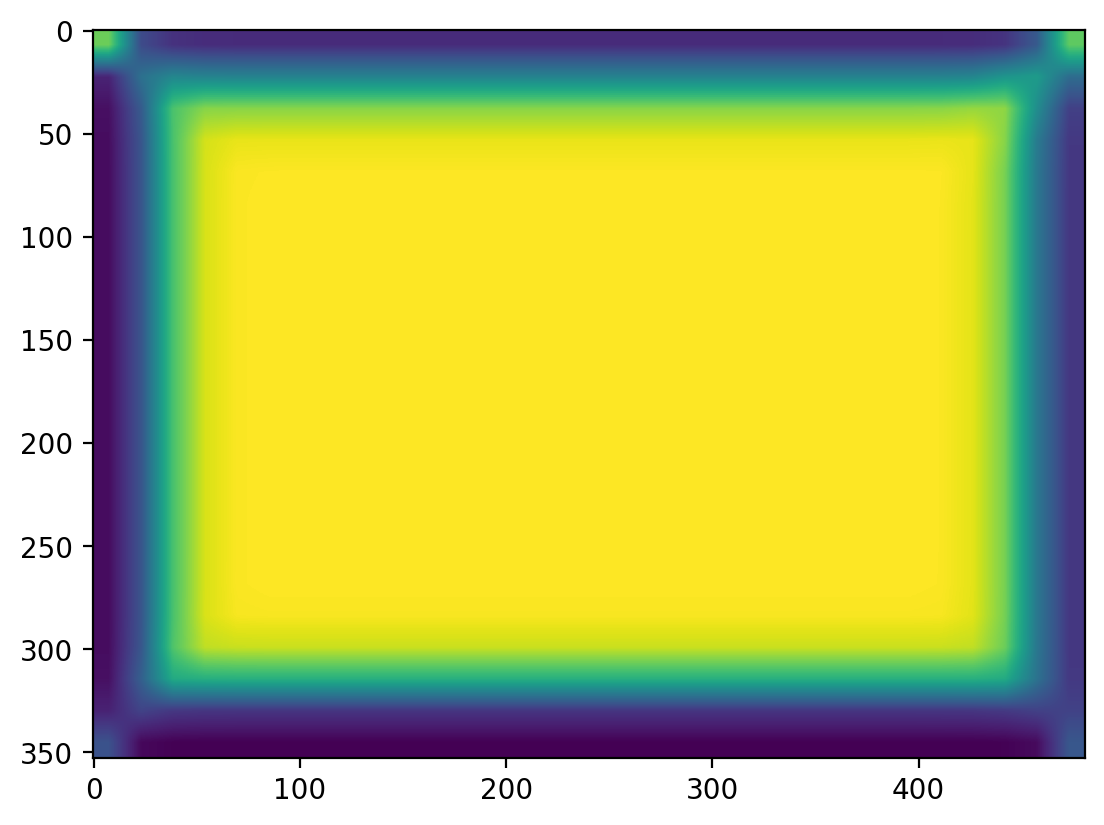

In [12]:
def overlay(img, over, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    out *= 1-alpha
    if len(over.shape)==2:
        out += alpha*over[:,:,np.newaxis]
    else:
        out += alpha*over    
    return out

# Here is the output map for right shoulder
Rshoulder_map = sample_output[0][0][:,:,config.KEYPOINTS.index('Rshoulder')]
plt.imshow(Rshoulder_map)

[[5.04173047e-06 5.39578043e-06 5.39578043e-06 ... 6.05302448e-06
  6.05302448e-06 6.05302448e-06]
 [5.04173047e-06 5.39578043e-06 5.39578043e-06 ... 6.05302448e-06
  6.05302448e-06 6.05302448e-06]
 [5.04173047e-06 5.39578043e-06 5.39578043e-06 ... 6.05302448e-06
  6.05302448e-06 6.05302448e-06]
 ...
 [1.59489354e-06 1.69782020e-06 1.69782020e-06 ... 2.47570647e-06
  2.47570647e-06 2.28449935e-06]
 [1.59489354e-06 1.69782020e-06 1.69782020e-06 ... 2.47570647e-06
  2.47570647e-06 2.28449935e-06]
 [1.59489354e-06 1.69782020e-06 1.69782020e-06 ... 2.29752401e-06
  2.29752401e-06 2.12007851e-06]]


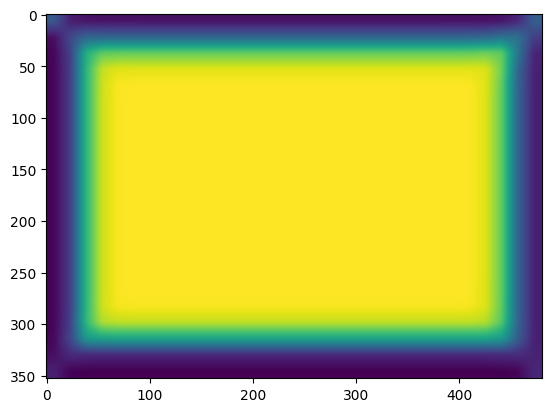

In [15]:
# Gaussian filtering helps when there are multiple local maxima for the same keypoint.
H = compute_heatmaps(kp_maps=sample_output[0][0], short_offsets=sample_output[1][0])
print(H[:,:,0])
for i in range(17):
    H[:,:,i] = gaussian_filter(H[:,:,i], sigma=2)
plt.imshow(H[:,:,config.KEYPOINTS.index('Rshoulder')]*10)

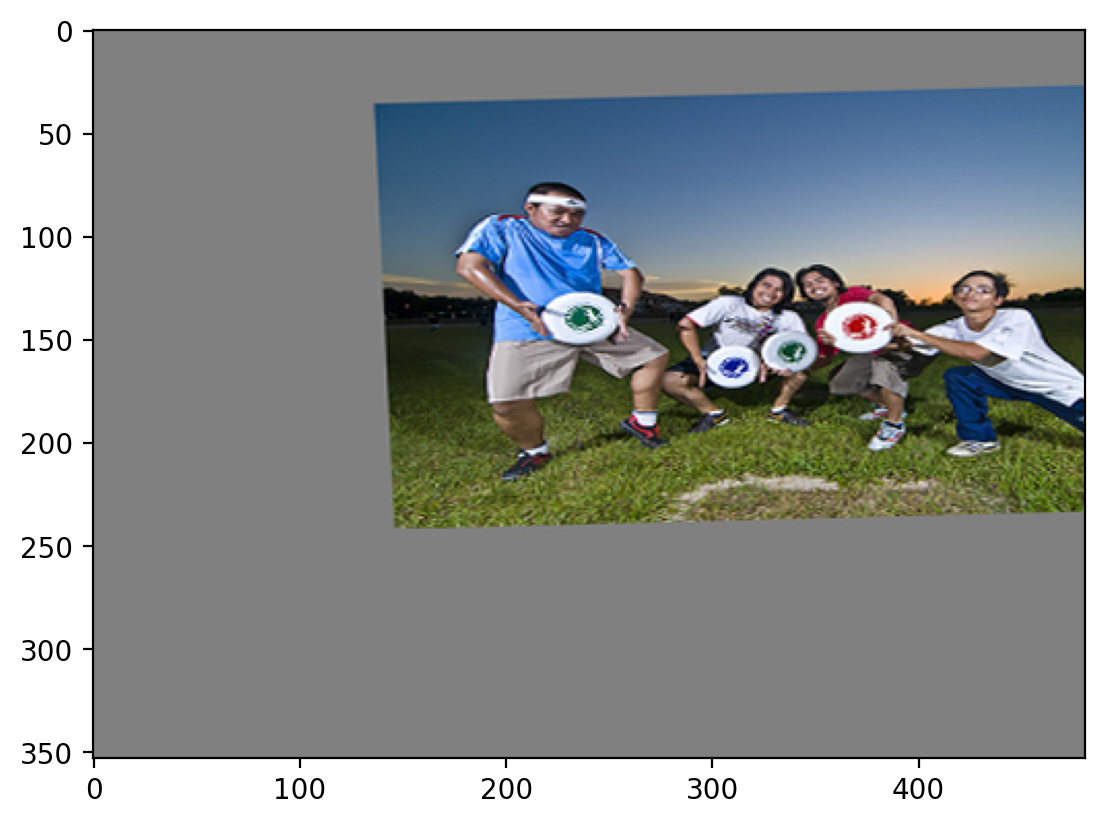

In [20]:
# The heatmaps are computed using the short offsets predicted by the network
# Here are the right shoulder offsets
visualize_short_offsets(offsets=sample_output[1][0], heatmaps=H, keypoint_id='Rshoulder', img=input_img[0][:,:,[2,1,0]], every=8)

In [24]:
pred_data = PredictionData(raw_kp_map[0])
kp_maps = pred_data.kp_heatmaps()


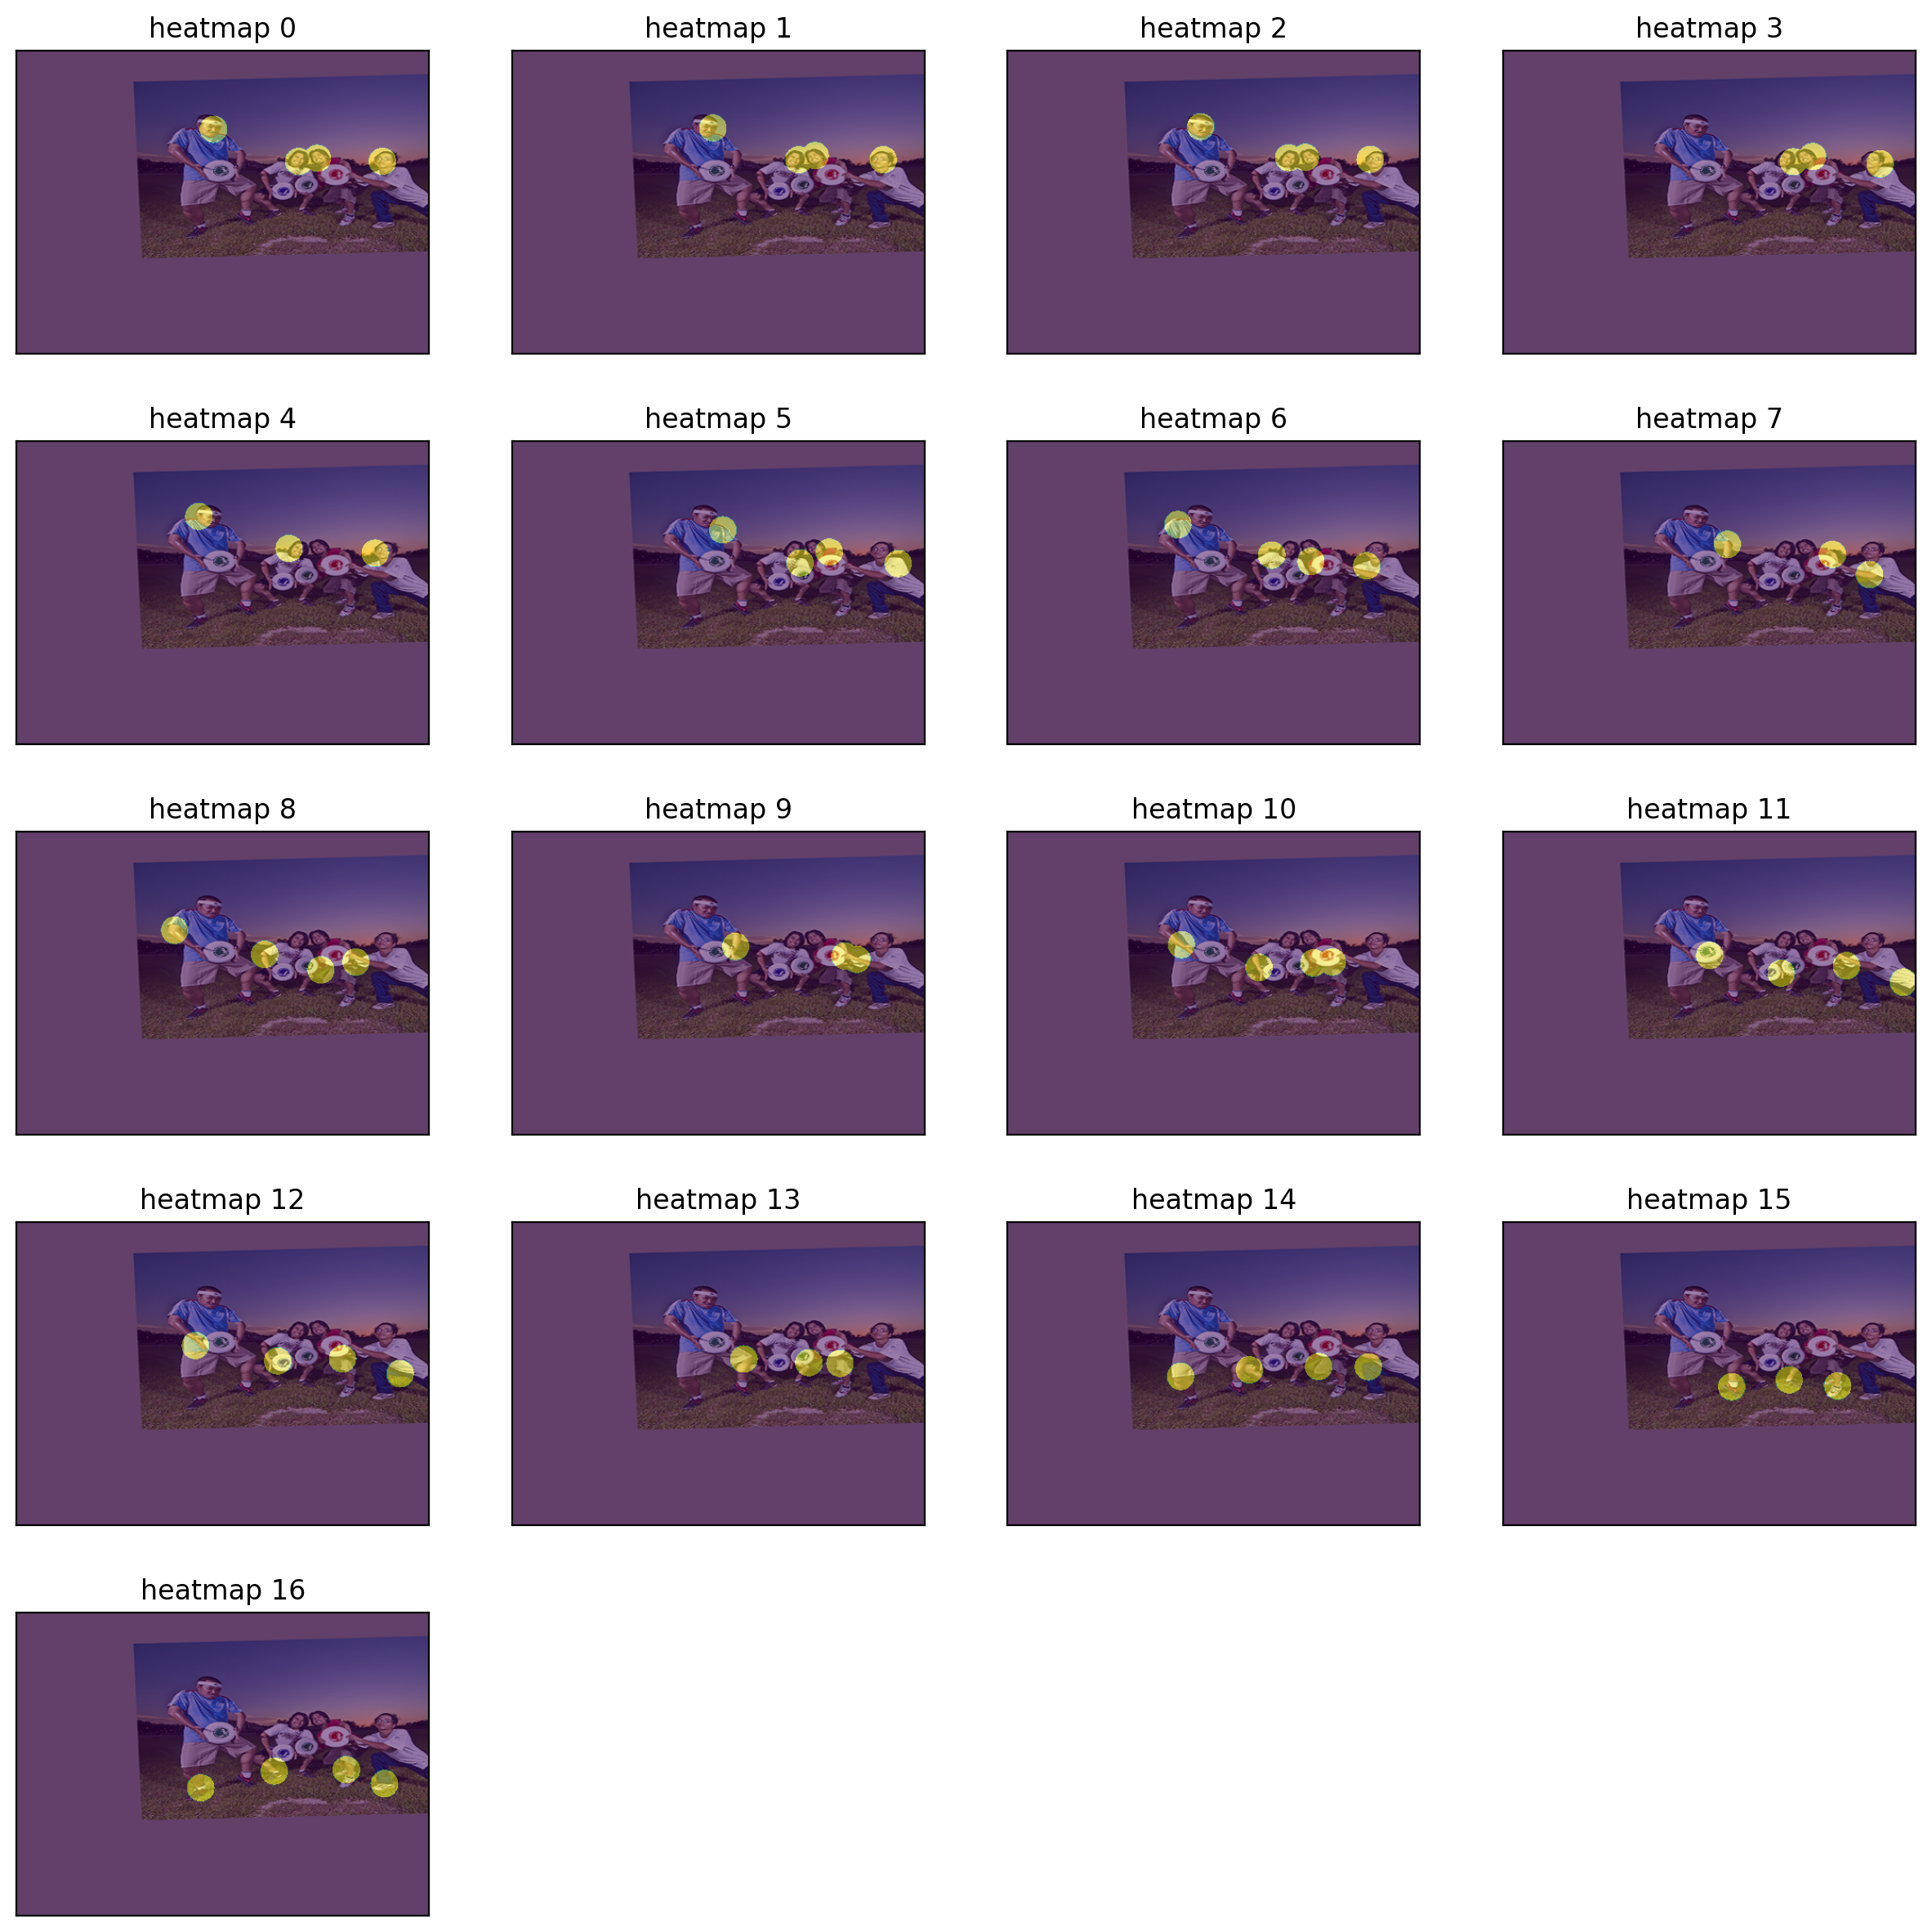

In [25]:
figure = plt.figure(figsize=(15, 15))
for i in range(17):
    plt.subplot(5, 4, i+1, title='heatmap {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_img[0][:,:,[2,1,0]])
    plt.imshow(kp_maps[:, :, i],alpha=0.5)